<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 8253, '日付': '2022-04-13T08:00:00.000Z'},
 {'小計': 8540, '日付': '2022-04-14T08:00:00.000Z'},
 {'小計': 6768, '日付': '2022-04-15T08:00:00.000Z'},
 {'小計': 6797, '日付': '2022-04-16T08:00:00.000Z'},
 {'小計': 5220, '日付': '2022-04-17T08:00:00.000Z'},
 {'小計': 3479, '日付': '2022-04-18T08:00:00.000Z'},
 {'小計': 5583, '日付': '2022-04-19T08:00:00.000Z'},
 {'小計': 6776, '日付': '2022-04-20T08:00:00.000Z'},
 {'小計': 6713, '日付': '2022-04-21T08:00:00.000Z'},
 {'小計': 5396, '日付': '2022-04-22T08:00:00.000Z'},
 {'小計': 5387, '日付': '2022-04-23T08:00:00.000Z'},
 {'小計': 4936, '日付': '2022-04-24T08:00:00.000Z'},
 {'小計': 3141, '日付': '2022-04-25T08:00:00.000Z'},
 {'小計': 5048, '日付': '2022-04-26T08:00:00.000Z'},
 {'小計': 6052, '日付': '2022-04-27T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-04-23 17:00:00+09:00,490,0,5387,2022-04-23 17:00:00+09:00
2022-04-24 17:00:00+09:00,408,0,4936,2022-04-24 17:00:00+09:00
2022-04-25 17:00:00+09:00,454,0,3141,2022-04-25 17:00:00+09:00
2022-04-26 17:00:00+09:00,396,0,5048,2022-04-26 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-04-23 17:00:00+09:00,490,0,5387,2022-04-23 17:00:00+09:00,450.142857,3151.0,0.0,0.0,5507.714286,38554.0
2022-04-24 17:00:00+09:00,408,0,4936,2022-04-24 17:00:00+09:00,448.285714,3138.0,0.0,0.0,5467.142857,38270.0
2022-04-25 17:00:00+09:00,454,0,3141,2022-04-25 17:00:00+09:00,435.857143,3051.0,0.0,0.0,5418.857143,37932.0
2022-04-26 17:00:00+09:00,396,0,5048,2022-04-26 17:00:00+09:00,426.285714,2984.0,0.0,0.0,5342.428571,37397.0
2022-04-27 17:00:00+09:00,0,0,6052,2022-04-27 17:00:00+09:00,365.857143,2561.0,0.0,0.0,5239.000000,36673.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-04-13 17:00:00+09:00,566,0,8253,2022-04-13 17:00:00+09:00,630.285714,4412.0,0.0,0.0,7532.857143,52730.0,'22w15,Wed
2022-04-14 17:00:00+09:00,482,0,8540,2022-04-14 17:00:00+09:00,614.714286,4303.0,0.0,0.0,7502.428571,52517.0,'22w15,Thu
2022-04-15 17:00:00+09:00,466,0,6768,2022-04-15 17:00:00+09:00,594.142857,4159.0,0.0,0.0,7310.428571,51173.0,'22w15,Fri
2022-04-16 17:00:00+09:00,526,0,6797,2022-04-16 17:00:00+09:00,560.285714,3922.0,0.0,0.0,7124.000000,49868.0,'22w15,Sat
2022-04-17 17:00:00+09:00,421,0,5220,2022-04-17 17:00:00+09:00,536.000000,3752.0,0.0,0.0,6723.142857,47062.0,'22w15,Sun
2022-04-18 17:00:00+09:00,541,0,3479,2022-04-18 17:00:00+09:00,516.714286,3617.0,0.0,0.0,6568.428571,45979.0,'22w16,Mon
2022-04-19 17:00:00+09:00,463,0,5583,2022-04-19 17:00:00+09:00,495.000000,3465.0,0.0,0.0,6377.142857,44640.0,'22w16,Tue
2022-04-20 17:00:00+09:00,423,0,6776,2022-04-20 17:00:00+09:00,474.571429,3322.0,0.0,0.0,6166.142857,43163.0,'22w16,Wed
2022-04-21 17:00:00+09:00,422,0,6713,2022-04-21 17:00:00+09:00,466.000000,3262.0,0.0,0.0,5905.142857,41336.0,'22w16,Thu
2022-04-22 17:00:00+09:00,391,0,5396,2022-04-22 17:00:00+09:00,455.285714,3187.0,0.0,0.0,5709.142857,39964.0,'22w16,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-04-10 17:00:00+09:00,7571.000000,52997
2022-04-17 17:00:00+09:00,6723.142857,47062
2022-04-24 17:00:00+09:00,5467.142857,38270
2022-04-27 17:00:00+09:00,4747.000000,14241
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-04-13 17:00:00+09:00,566,0,8253,2022-04-13 17:00:00+09:00,630.285714,4412.0,0.0,0.0,7532.857143,52730.0,'22w15,Wed,NaN,NaN
2022-04-14 17:00:00+09:00,482,0,8540,2022-04-14 17:00:00+09:00,614.714286,4303.0,0.0,0.0,7502.428571,52517.0,'22w15,Thu,NaN,NaN
2022-04-15 17:00:00+09:00,466,0,6768,2022-04-15 17:00:00+09:00,594.142857,4159.0,0.0,0.0,7310.428571,51173.0,'22w15,Fri,NaN,NaN
2022-04-16 17:00:00+09:00,526,0,6797,2022-04-16 17:00:00+09:00,560.285714,3922.0,0.0,0.0,7124.000000,49868.0,'22w15,Sat,NaN,NaN
2022-04-17 17:00:00+09:00,421,0,5220,2022-04-17 17:00:00+09:00,536.000000,3752.0,0.0,0.0,6723.142857,47062.0,'22w15,Sun,6723.142857,47062.0
2022-04-18 17:00:00+09:00,541,0,3479,2022-04-18 17:00:00+09:00,516.714286,3617.0,0.0,0.0,6568.428571,45979.0,'22w16,Mon,NaN,NaN
2022-04-19 17:00:00+09:00,463,0,5583,2022-04-19 17:00:00+09:00,495.000000,3465.0,0.0,0.0,6377.142857,44640.0,'22w16,Tue,NaN,NaN
2022-04-20 17:00:00+09:00,423,0,6776,2022-04-20 17:00:00+09:00,474.571429,3322.0,0.0,0.0,6166.142857,43163.0,'22w16,Wed,NaN,NaN
2022-04-21 17:00:00+09:00,422,0,6713,2022-04-21 17:00:00+09:00,466.000000,3262.0,0.0,0.0,5905.142857,41336.0,'22w16,Thu,NaN,NaN
2022-04-22 17:00:00+09:00,391,0,5396,2022-04-22 17:00:00+09:00,455.285714,3187.0,0.0,0.0,5709.142857,39964.0,'22w16,Fri,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

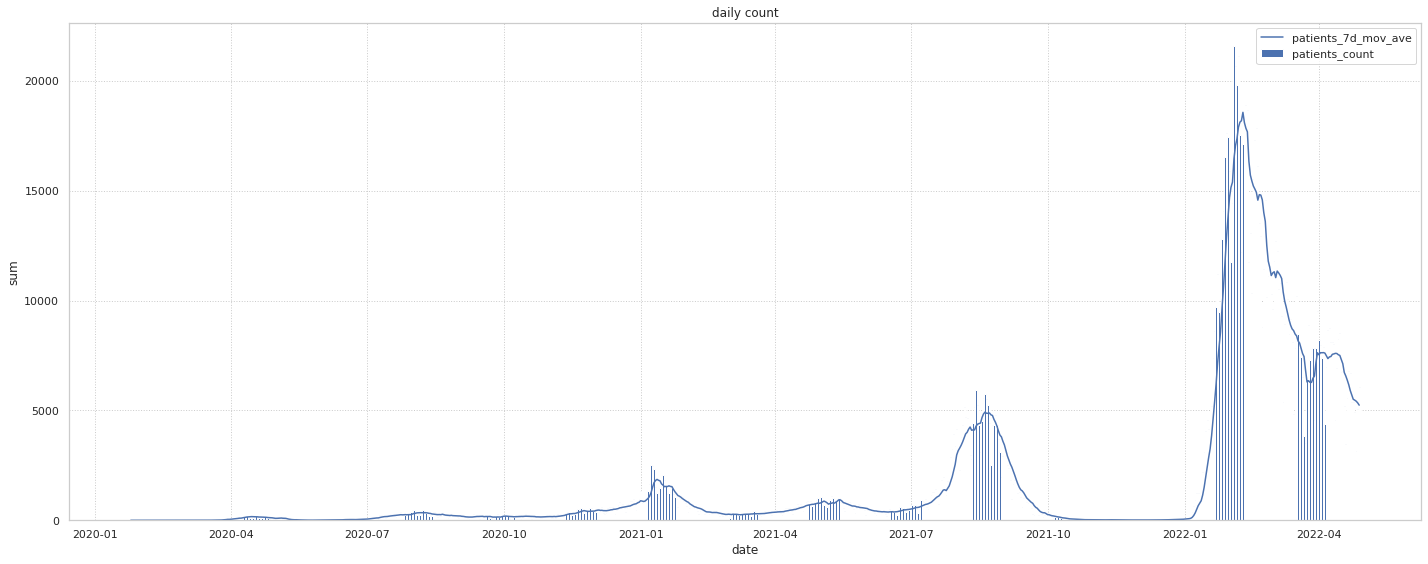

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
810,1.649837e+09,2022,4,13,0,0,0,0,0,0,...,736,566,630.285714,4412.0,0,0.0,0.0,8253,7532.857143,52730.0
811,1.649923e+09,2022,4,14,0,0,0,0,1,0,...,737,482,614.714286,4303.0,0,0.0,0.0,8540,7502.428571,52517.0
812,1.650010e+09,2022,4,15,1,0,0,0,0,0,...,738,466,594.142857,4159.0,0,0.0,0.0,6768,7310.428571,51173.0
813,1.650096e+09,2022,4,16,0,0,1,0,0,0,...,739,526,560.285714,3922.0,0,0.0,0.0,6797,7124.000000,49868.0
814,1.650182e+09,2022,4,17,0,0,0,1,0,0,...,740,421,536.000000,3752.0,0,0.0,0.0,5220,6723.142857,47062.0
815,1.650269e+09,2022,4,18,0,1,0,0,0,0,...,741,541,516.714286,3617.0,0,0.0,0.0,3479,6568.428571,45979.0
816,1.650355e+09,2022,4,19,0,0,0,0,0,1,...,742,463,495.000000,3465.0,0,0.0,0.0,5583,6377.142857,44640.0
817,1.650442e+09,2022,4,20,0,0,0,0,0,0,...,743,423,474.571429,3322.0,0,0.0,0.0,6776,6166.142857,43163.0
818,1.650528e+09,2022,4,21,0,0,0,0,1,0,...,744,422,466.000000,3262.0,0,0.0,0.0,6713,5905.142857,41336.0
819,1.650614e+09,2022,4,22,1,0,0,0,0,0,...,745,391,455.285714,3187.0,0,0.0,0.0,5396,5709.142857,39964.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            825 non-null    float64
 1   year                 825 non-null    int64  
 2   month                825 non-null    int64  
 3   day                  825 non-null    int64  
 4   Fri                  825 non-null    uint8  
 5   Mon                  825 non-null    uint8  
 6   Sat                  825 non-null    uint8  
 7   Sun                  825 non-null    uint8  
 8   Thu                  825 non-null    uint8  
 9   Tue                  825 non-null    uint8  
 10  Wed                  825 non-null    uint8  
 11  passed               825 non-null    int64  
 12  emergency            825 non-null    int64  
 13  em_passed            825 non-null    int64  
 14  contacts_count       825 non-null    int64  
 15  contacts_7d_mov_ave  825 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.250000e+02,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,...,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000
mean,1.615450e+09,2020.726061,6.098182,15.763636,0.143030,0.143030,0.143030,0.143030,0.141818,0.143030,...,341.363636,682.797576,681.691573,4771.836364,446.689697,446.689697,3126.827879,1729.087273,1710.892000,11976.224242
std,2.058923e+07,0.695067,3.470235,8.804712,0.350316,0.350316,0.350316,0.350316,0.349075,0.350316,...,233.092967,546.897313,534.729254,3743.110679,767.174350,706.178653,4943.250569,3610.840315,3524.997192,24674.989944
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.597651e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,132.000000,334.000000,339.000000,2373.000000,0.000000,0.000000,0.000000,65.000000,70.000000,490.000000
50%,1.615450e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,338.000000,519.000000,539.571429,3777.000000,0.000000,0.000000,0.000000,301.000000,308.142857,2157.000000
75%,1.633248e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,544.000000,827.000000,833.857143,5837.000000,878.000000,1012.285714,7086.000000,920.000000,874.571429,6122.000000
max,1.651046e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,750.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.909128,0.070879,0.003617,-0.004289,0.000858,-0.002573,-0.000858,-1.984601e-16,0.002573,...,0.998841,-0.036321,-0.024657,-0.024655,-0.618440,-0.663884,-0.663884,0.552873,0.563523,0.563524
year,9.091276e-01,1.000000,-0.349586,-0.030225,-0.003365,0.001619,0.001619,0.001619,-4.747170e-03,0.001619,...,0.914349,0.075853,0.087414,0.087415,-0.608954,-0.661552,-0.661552,0.664343,0.672574,0.672574
month,7.087885e-02,-0.349586,1.000000,-0.002417,-0.001583,-0.002581,-0.009569,-0.006574,1.153382e-02,0.002410,...,0.055640,-0.265441,-0.265955,-0.265953,0.068550,0.093284,0.093284,-0.348856,-0.344073,-0.344072
day,3.617339e-03,-0.030225,-0.002417,1.000000,-0.000043,0.007433,-0.002010,0.008613,-1.320973e-03,-0.005551,...,0.004172,0.011802,-0.000849,-0.000851,0.004600,-0.005560,-0.005560,-0.013134,-0.019086,-0.019086
Fri,-4.288528e-03,-0.003365,-0.001583,-0.000043,1.000000,-0.166902,-0.166902,-0.166902,-1.660763e-01,-0.166902,...,-0.003907,-0.017351,-0.001404,-0.001404,0.024351,-0.000313,-0.000313,0.017063,-0.001581,-0.001581
Mon,8.577057e-04,0.001619,-0.002581,0.007433,-0.166902,1.000000,-0.166902,-0.166902,-1.660763e-01,-0.166902,...,0.000863,0.039982,-0.000153,-0.000152,0.097134,-0.000313,-0.000313,-0.067121,0.000309,0.000309
Sat,-2.573117e-03,0.001619,-0.009569,-0.002010,-0.166902,-0.166902,1.000000,-0.166902,-1.660763e-01,-0.166902,...,-0.002317,0.046608,-0.000951,-0.000950,-0.112744,-0.000313,-0.000313,0.012022,-0.000824,-0.000825
Sun,-8.577057e-04,0.001619,-0.006574,0.008613,-0.166902,-0.166902,-0.166902,1.000000,-1.660763e-01,-0.166902,...,-0.000727,-0.024585,-0.000573,-0.000573,-0.103897,-0.000313,-0.000313,-0.011478,-0.000132,-0.000132
Thu,-1.984601e-16,-0.004747,0.011534,-0.001321,-0.166076,-0.166076,-0.166076,-0.166076,1.000000e+00,-0.166076,...,-0.000426,-0.012201,0.002660,0.002660,0.030259,0.001885,0.001885,0.031265,-0.000660,-0.000660
Tue,2.573117e-03,0.001619,0.002410,-0.005551,-0.166902,-0.166902,-0.166902,-0.166902,-1.660763e-01,1.000000,...,0.002454,-0.016705,0.000214,0.000214,0.038580,-0.000313,-0.000313,-0.011159,0.001018,0.001018


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,1.650701e+09,0,0,1,0,0,0,0,820,0,746,490,0,5387,5507.714286,38554.0
821,1.650787e+09,0,0,0,1,0,0,0,821,0,747,408,0,4936,5467.142857,38270.0
822,1.650874e+09,0,1,0,0,0,0,0,822,0,748,454,0,3141,5418.857143,37932.0
823,1.650960e+09,0,0,0,0,0,1,0,823,0,749,396,0,5048,5342.428571,37397.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
820,1.650701e+09,820,0,5387,5507.714286,38554.0
821,1.650787e+09,821,0,4936,5467.142857,38270.0
822,1.650874e+09,822,0,3141,5418.857143,37932.0
823,1.650960e+09,823,0,5048,5342.428571,37397.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

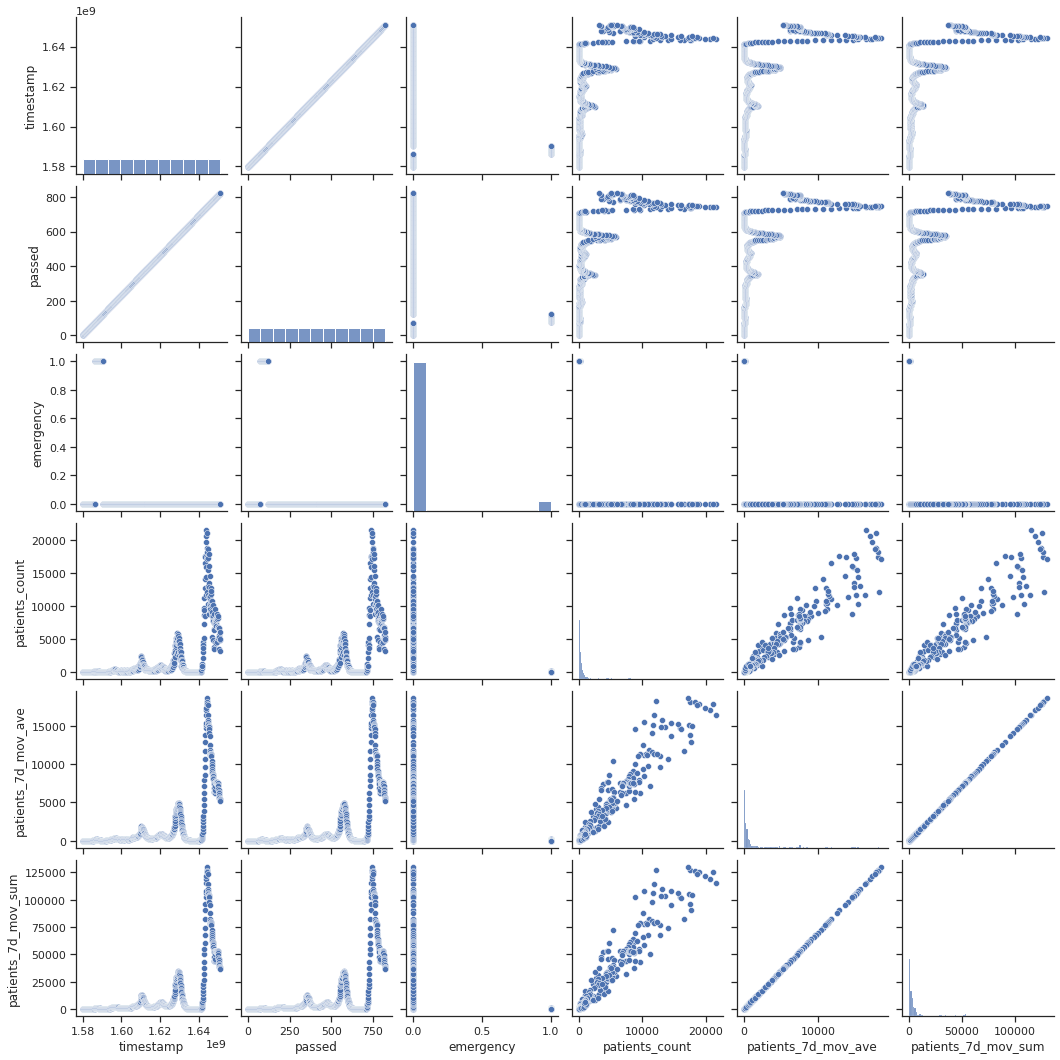

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.0
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==